Found 2627 images belonging to 2 classes.
Found 328 images belonging to 2 classes.
Found 329 images belonging to 2 classes.
Epoch 1/10
83/83 [==============================] - 15s 175ms/step - loss: 0.5265 - accuracy: 0.7164 - val_loss: 0.4381 - val_accuracy: 0.7866
Epoch 2/10
83/83 [==============================] - 3s 37ms/step - loss: 0.4133 - accuracy: 0.8146 - val_loss: 0.4084 - val_accuracy: 0.7988
Epoch 3/10
83/83 [==============================] - 3s 37ms/step - loss: 0.3698 - accuracy: 0.8306 - val_loss: 0.3449 - val_accuracy: 0.8201
Epoch 4/10
83/83 [==============================] - 3s 37ms/step - loss: 0.3446 - accuracy: 0.8302 - val_loss: 0.3125 - val_accuracy: 0.8598
Epoch 5/10
83/83 [==============================] - 3s 37ms/step - loss: 0.3489 - accuracy: 0.8317 - val_loss: 0.3822 - val_accuracy: 0.8079
Epoch 6/10
83/83 [==============================] - 3s 37ms/step - loss: 0.3221 - accuracy: 0.8435 - val_loss: 0.2974 - val_accuracy: 0.8659
Epoch 7/10
83/83 [==========

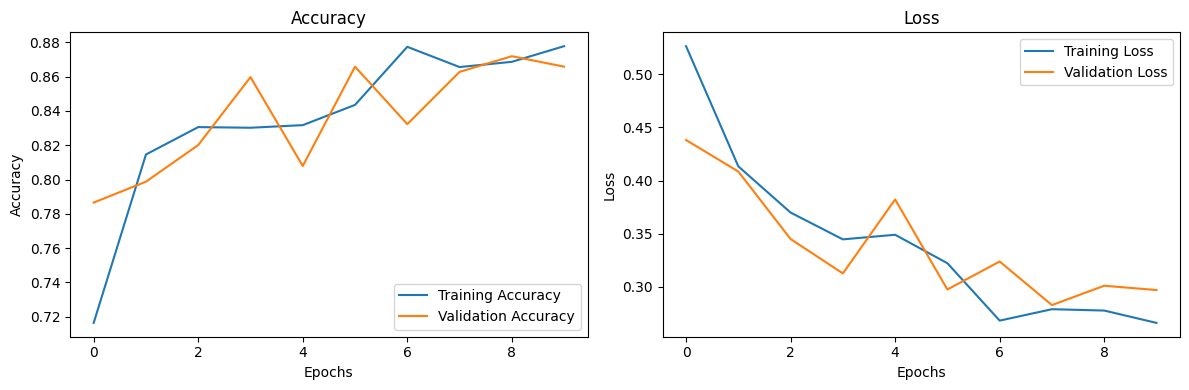

In [2]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image

# Function to get image paths and labels
def load_data(concrete_dir, non_concrete_dir, temp_dir, img_size=(150, 150)):
    if os.path.exists(temp_dir):
        shutil.rmtree(temp_dir)  # Clear temporary directory if it exists
    os.makedirs(temp_dir, exist_ok=True)

    # Prepare image paths and labels
    image_paths, labels = [], []

    for label, folder in enumerate([concrete_dir, non_concrete_dir]):
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(folder, filename))
                labels.append(label)  # 0 for concrete, 1 for non-concrete

    # Split data into training (80%), validation (10%), and test (10%)
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=0.2, random_state=42
    )
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        test_paths, test_labels, test_size=0.5, random_state=42
    )

    # Function to copy images into directories
    def copy_images(image_paths, labels, dest_folder):
        for path, label in zip(image_paths, labels):
            class_folder = os.path.join(dest_folder, str(label))
            os.makedirs(class_folder, exist_ok=True)
            shutil.copy(path, os.path.join(class_folder, os.path.basename(path)))

    # Create directories for train, validation, and test sets
    for dataset, paths, labels in [("train", train_paths, train_labels),
                                   ("val", val_paths, val_labels),
                                   ("test", test_paths, test_labels)]:
        copy_images(paths, labels, os.path.join(temp_dir, dataset))

    return os.path.join(temp_dir, 'train'), os.path.join(temp_dir, 'val'), os.path.join(temp_dir, 'test')

# Ask user for paths
concrete_dir = "Untouched\Concrete"
non_concrete_dir = "Untouched\Rural"

# Temporary directory for structured data
temp_dir = "temp_image_data"

# Load and prepare data
train_dir, val_dir, test_dir = load_data(concrete_dir, non_concrete_dir, temp_dir)

# Image data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255)
val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(150, 150), batch_size=32, class_mode='binary'
)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.2f}")

# Plot accuracy and loss graphs
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
model.save("concrete_vs_non_concrete_model.h5")
